In [71]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, DynamicVAR
import statsmodels.api as sm
%matplotlib inline

In [73]:
mdata = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b) Without predictors

In [74]:
## VAR
dates = mdata['Date']
data = mdata[['r','xs','xb']]
data.index = pd.DatetimeIndex(dates)

model = VAR(data[['r','xs','xb']])
results = model.fit(1)   # fit a VAR(1) model on the data based on only the returns (no predictability)
A = results.coefs

results.summary()

sim = [[0 for x in range(mdata.shape[1]-1)] for k in range(0,mdata.shape[0])] 
eps = np.sqrt(np.var(results.resid)).values.reshape(1,3)
x0 = np.random.normal(0,eps[0][0],mdata.shape[0])
x1 = np.random.normal(0,eps[0][1],mdata.shape[0])
x2 = np.random.normal(0,eps[0][2],mdata.shape[0])


for k in range(0,mdata.shape[0]):
    if k == 0:
        Ahat = data[0:1].values.dot(A[0].transpose())
        Ahat = Ahat[0]
    else:
        Ahat = np.array(np.array(sim[k-1]).dot(A[0].transpose()))
    sim[k][0] = Ahat[0] + x0[k]
    sim[k][1] = Ahat[1] + x1[k]
    sim[k][2] = Ahat[2] + x2[k]

tempdata = pd.DataFrame(sim)
tempdata.columns = mdata.columns[1:4]
tempdata.index = dates
data = tempdata

In [75]:
# Write away the simulated data in order for it to be reused in each model
data.to_excel('sim_data_VAR.xlsx', sheet_name='sheet1')

In [81]:
# Read written away simulated data
data = pd.read_excel('sim_data_VAR.xlsx') #Three stocks (R,X_s,X_b) Without predictors
data.index = data['Date']
del data['Date']

                  r        xs        xb
Date                                   
2/1/1954   0.003184  0.022340  0.009670
3/1/1954  -0.003993  0.027806  0.005929
4/1/1954  -0.004400  0.006786 -0.003799
5/1/1954   0.001810  0.027377 -0.029562
6/1/1954  -0.004079 -0.034146  0.010878
7/1/1954  -0.004846  0.041801  0.027714
8/1/1954  -0.003312 -0.006369 -0.016609
9/1/1954  -0.000443  0.015344 -0.009590
10/1/1954 -0.000593  0.036824  0.029063
11/1/1954 -0.002340  0.014200  0.002268
12/1/1954 -0.001156  0.021987  0.039684
1/1/1955  -0.001236 -0.014078 -0.017789
2/1/1955  -0.006436  0.002952  0.002558
3/1/1955  -0.005278  0.010900  0.004598
4/1/1955  -0.001362  0.057489  0.007800
5/1/1955   0.002148  0.029501 -0.001167
6/1/1955  -0.000398 -0.016149  0.003324
7/1/1955  -0.001351 -0.046258  0.006478
8/1/1955  -0.001478  0.028633 -0.019552
9/1/1955  -0.006573 -0.115564 -0.005503
10/1/1955 -0.005559 -0.048626 -0.001902
11/1/1955 -0.003123  0.067125 -0.004928
12/1/1955 -0.008852  0.007493 -0.002825


0.94061227811
1.01502068065
0.849279647907
0.990433672825
0.0954675300203
0.0500358357301
0.228648191537
0.090521863774


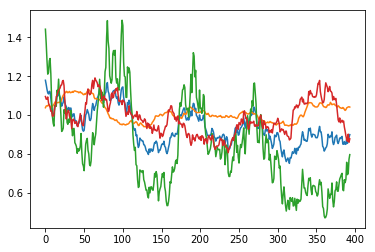

In [60]:
# Model-free benchmarks (1/N or full in the other assets)
# index 239 is the beginning of the out-of-sample analysis 754 (last)
a0 = [1/3,1/3,1/3]
a1 = [1,0,0]
a2 = [0,1,0]
a3 = [0,0,1]

r0list = []
r1list = []
r2list = []
r3list = []
for i in range(239,753-120):
    r0 = 0
    r1 = 0
    r2 = 0
    r3 = 0
    for j in range(1,60):
        s1 = data.iloc[i+j,0:4].values.reshape(1,3)
        r0 += sum(a0*s1[0])
        r1 += sum(a1*s1[0])
        r2 += sum(a2*s1[0])
        r3 += sum(a3*s1[0])
    # transform from cumulative log return to Terminal wealth (given starting wealth is normalized to 1)
    r0 = np.exp(r0)
    r1 = np.exp(r1)
    r2 = np.exp(r2)
    r3 = np.exp(r3)
    r0list.append(r0)
    r1list.append(r1)
    r2list.append(r2)
    r3list.append(r3)
    
plt.plot(r0list)
plt.plot(r1list)
plt.plot(r2list)
plt.plot(r3list)

print(np.mean(r0list))
print(np.mean(r1list))
print(np.mean(r2list))
print(np.mean(r3list))

print(np.sqrt(np.var(r0list)))
print(np.sqrt(np.var(r1list)))
print(np.sqrt(np.var(r2list)))
print(np.sqrt(np.var(r3list)))

df = pd.DataFrame({'1/N':r0list, 'full r': r1list, 'full Xs':r2list,'full Xb':r3list})
df.to_excel('Results_MF_Benchmark.xlsx', sheet_name='sheet1')
    

In [ ]:
# Model benchmark (classical portfolio management) NEEDS OPTIMIZATION ESPECIALLY FOR LARGER RUNS, sim and slice)
# expanding window + investment horizon = 5 years (K = 60)

# parsing data
dates = data.index
mdata = data[['r','xs','xb']]
mdata.index = pd.DatetimeIndex(dates)
n = data.size/4-4
periods = 60
simul = 400
beginperiod = 241
gamma = 2 #5 #2 
TW = []
MWeights = []
Index = []
Turnover = []
RU = []

for i in range(beginperiod,int(n-periods-1)): #   n-periods-1): (possiblity to serialize) (Check 241 )
    # initialization
    optimalweights = np.zeros(periods-1)
    currentK = 0
    
    while currentK < periods-1:
        K = periods - currentK
        
        ## Simulate from the estimate VAR(1) model
        model = VAR(mdata[0:i+currentK]) # take a smaller range to improve speed (like i - 200)
        results = model.fit(1)   # fit a VAR(1) model on the data based on only the returns (no predictability)
        A = results.coefs
        sim = [[[0 for x in range(3)] for k in range(0,K)] for j in range(0,simul)]
        for j in range(0,simul):
            eps = np.sqrt(np.var(results.resid)).values.reshape(1,3)
            x0 = np.random.normal(0,eps[0][0],K)
            x1 = np.random.normal(0,eps[0][1],K)
            x2 = np.random.normal(0,eps[0][2],K)

            for k in range(0,K):
                if k == 0:
                    Ahat = mdata[i:i+1+currentK].values.dot(A[0].transpose())
                    Ahat = Ahat[0]
                else:
                    Ahat = np.array(np.array(sim[j][k-1]).dot(A[0].transpose()))
                sim[j][k][0] = Ahat[0] + x0[k]
                sim[j][k][1] = Ahat[1] + x1[k]
                sim[j][k][2] = Ahat[2] + x2[k]
                
        ## Calculate the optimal weights 
        W = np.linspace(0,1,10)
        Ufut = np.ones(simul)
        OptU = np.ones(simul)*-999
        OptW = np.zeros(simul)
        U = np.zeros(simul)

        for k in range(1,K+1):
            if k < K:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*(pow((w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2])),(1-gamma))*Ufut[j])
                        # Eventually K-k-1 because now i calculate fut Utility of time period T+K+1
                    slice = []
                    for x in range(0,simul):
                        slice.append(sim[x][K-k][1:3])
                    slice = sm.add_constant(slice)
                    olsmodel = sm.OLS(U, slice)
                    CU = olsmodel.fit()
#                     print(CU.params)
                    CU = np.sum(slice * CU.params, axis=1)
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w
                slicexs = []
                slicexb = []
                for x in range(0,simul):
                    slicexs.append(sim[x][K-k][1])
                    slicexb.append(sim[x][K-k][2])
                Ufut = (pow(OptW*np.exp(slicexs) + (1-OptW)*np.exp(slicexb),(1-gamma))*Ufut)
#                 print(OptW*np.exp(slicexs))
                OptU = np.ones(simul)*-999
                OptW = np.zeros(simul)
            else:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*((pow(w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2]),(1-gamma)))*Ufut[j])
                    olsmodel = sm.OLS(U, np.ones(simul))
                    CU = olsmodel.fit()
                    CU = np.ones(simul) * CU.params
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w

        optimalweights[currentK] = OptW[1] 
        currentK += 1
    print(i)
    firstdiff = optimalweights[1:] - optimalweights[:-1]
    
    # Calculate the Terminal Wealth from the given optimalweights  (Check whether indexes are right)
    TerminalWealth = np.exp(sum(optimalweights*mdata[i+1:i+currentK+1]['xs'] + (1-optimalweights)*mdata[i+1:i+currentK+1]['xb']))
    TW.append(TerminalWealth)
    # Mean of the weights
    MWeights.append(np.mean(optimalweights))
    # Index value in time
    Index.append(i)
    # Turnover
    Turnover.append(sum(abs(firstdiff*np.exp(mdata[i+1:i+currentK]['xs'])) + abs((1-firstdiff)*np.exp(mdata[i+1:i+currentK]['xb']))))
    # Realized Utility
    RU.append((1/(1-gamma))*pow(TerminalWealth,(1-gamma)))
    
    print('Writing away results')
    #     df = pd.DataFrame({'index date':Index,'TW':TW, 'Mean Weights Xs':MWeights})
    df = pd.DataFrame({'index date':Index,'TW':TW, 'Mean Weights Xs':MWeights,'Turnover':Turnover, 'Realized Utility':RU})
    df.to_excel('Sim_ResultsExp_CP_g10_gamma2.xlsx', sheet_name='sheet1', index=False)
